In [167]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
import numpy as np
from tools import *
from fitters import *
from plots import *
set_seaborn({'figure.figsize': (8,6)})


In [169]:
noise = 1e-6
beta = 0
e_s = np.array([-0.8, -0.15, 1.5])
a_s = np.array([1.0, 0.2, 0.01])
dim = 8
dt = 0.1
time = np.arange(0, 3+dt, dt)
N = len(time)
true_eigs = np.sort(np.exp(e_s*dt))[::-1]

# build X_series
noise_series = noise * np.random.randn(N)
components = []
for i in range(len(e_s)):
    c = exp_f(time, e_s[i], a_s[i])
    components.append(c)
X_series = np.sum(components, axis=0)
X_series_noise = X_series + noise_series


# build Y_series
Y_series = components[np.argmax(e_s)]
Y_series = Y_series[dim:]

In [170]:
# ALGO
Xhan = build_hankel(X_series_noise, dim)
X0 = Xhan[:, :-1]
Xp = Xhan[:, 1:]
lam = beta * np.eye(dim)
X0Xp = X0 @ Xp.T
X0X0 = X0 @ X0.T
# solve eigenvalue problem
w, vl = scipy.linalg.eig(
    X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

theta = vl[:, np.nanargmax(np.abs(w))]
w = np.sort(np.real_if_close(w))[::-1]

theta /= theta[-1]
pred_series = theta.real @ Xhan
pred_series /= pred_series[0]/Y_series[0]


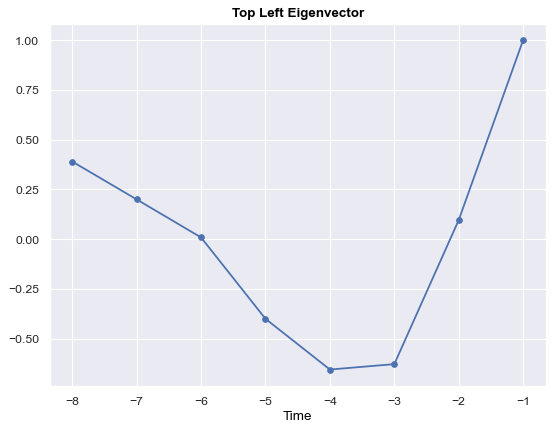

In [171]:
plt.plot(np.arange(-dim,0), theta.real, '.-');
plt.xlabel('Time')
plt.title('Top Left Eigenvector')
plt.show()

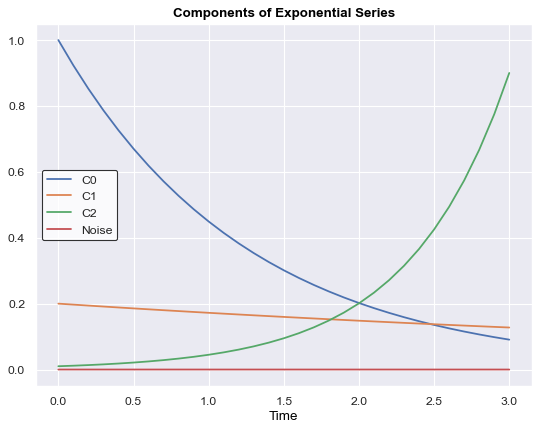

In [172]:
[plt.plot(time, c, label=f'C{i}') for i,c in enumerate(components)]
plt.plot(time, noise_series, label='Noise')
plt.legend()
plt.xlabel('Time')
plt.title('Components of Exponential Series')
plt.show()

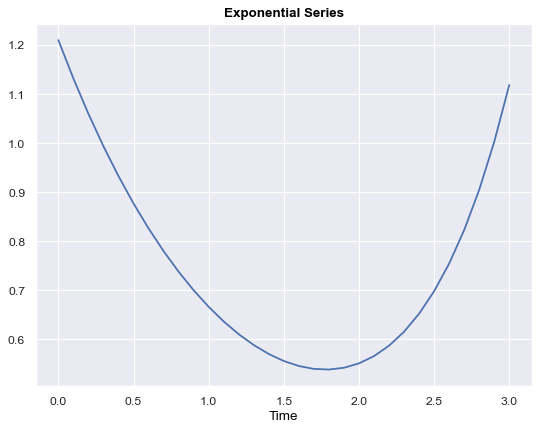

In [164]:
plt.plot(time, X_series_noise);
plt.xlabel('Time')
plt.title('Exponential Series')
plt.show()

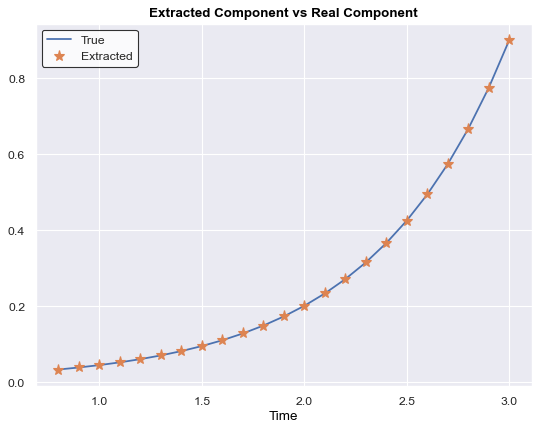

In [165]:
plt.plot(time[dim:], Y_series, label='True');
plt.plot(time[dim:], pred_series, '*', label='Extracted');
plt.legend()
plt.xlabel('Time')
plt.title('Extracted Component vs Real Component')
plt.show()

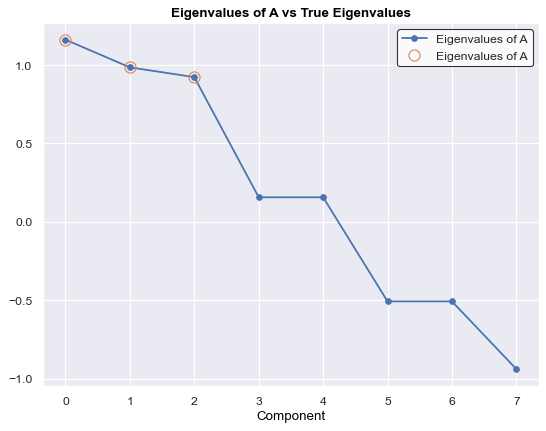

In [166]:
plt.plot(w.real, '.-', label='Eigenvalues of A');
plt.plot(true_eigs, 'o', fillstyle='none', label='Eigenvalues of A');
plt.legend()
plt.xlabel('Component')
plt.title('Eigenvalues of A vs True Eigenvalues')
plt.show()